### Simple example
This code shows as simple way to:
- Read in a .nc file using xarray
- Calculate annual values
- Plot global time series
- Plot spatial maps

In [1]:
import xarray as xr
import cf_units as cf
import esmlab
from ctsm_py import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
#import hvplot.xarray
#import holoviews as hv
#hv.extension('bokeh')
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = ['NFIX','GPP']
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[0]+'.185001-201412.nc' 
file2 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[1]+'.185001-201412.nc' 
file

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.NFIX.185001-201412.nc'

#### Read in your data

In [3]:
# ?? Wrapping the time_set_mid utility corrects time being read in by xr.open_dataset, other options ??
# ?? Would be nice to build a way to read in multiple models here, maybe build on Keith L's Example ??
# data sets have lots of coords, variables, and attributes
#ds   = xr.open_dataset(file, decode_times=True)
ds   = utils.time_set_mid(xr.open_dataset(file, decode_times=True), 'time')
ds2  = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')
area = ds.area
landfrac = ds.landfrac
da = ds[var[0]]    # strips out the extra coords and variables from the dataset
dataset = da.to_dataset()  # convert the previously created unnamed DataArray to Dataset with a variable named "array"
dataset[var[1]] = ds2[var[1]]
dataset

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Data variables:
    NFIX     (time, lat, lon) float32 ...
    GPP      (time, lat, lon) float32 ...

#### Make weights for global sum

In [4]:
# ?? Would be nice to use cfunits  here ??
landUp = area * landfrac * 1e6      # area in km2, not m2
orig_units = cf.Unit(landUp.attrs['units'])
target_units = cf.Unit('m^2')
landUp.attrs['units'] = target_units# rename units
area_wgt = landUp / landUp.sum()    # weighting for each grid cell
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 

#### Convert monthly to annual

In [5]:
# apply iterates through all variables in a dataset and applies the function to each variable.
# ?? Would be nice to do this differently for fluxes & stocks ??
mean_dataset = dataset.apply(utils.weighted_annual_mean) * spy
mean_dataset[var[0]].attrs['units'] = 'gN m-2 y-1'
mean_dataset[var[1]].attrs['units'] = 'gC m-2 y-1'
print(mean_dataset)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 165)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    NFIX     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    GPP      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan


#### Calculate global sums

In [6]:
# ?? This could also be done regionally (see Paul's comments on google doc) ??
mean_wgt = mean_dataset * landUp
ann_glob = mean_wgt.sum(dim=('lat','lon')) * 1e-12 #convert to g/y
ann_glob[var[1]]= mean_wgt[var[1]].sum(dim=('lat','lon')) * 1e-15 #convert to g/y
ann_glob[var[0]].attrs['units'] = 'Tg N y^-1'
ann_glob[var[1]].attrs['units'] = 'Pg C y^-1'
print(ann_glob)

<xarray.Dataset>
Dimensions:  (time: 165)
Coordinates:
  * time     (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    NFIX     (time) float64 30.65 30.0 31.43 33.46 ... 63.8 62.51 63.58 63.13
    GPP      (time) float64 97.99 97.83 97.77 98.42 ... 124.6 121.3 122.3 122.4


-----------------------------
### Make a line plot

['NFIX', 'GPP']


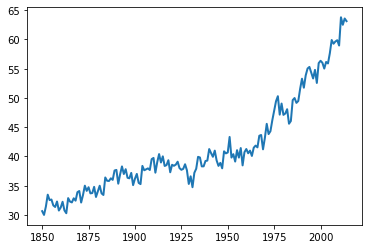

In [7]:
plt.plot(ann_glob.coords['time.year'], ann_glob['NFIX'], '-' ,lw=2)
print(var)

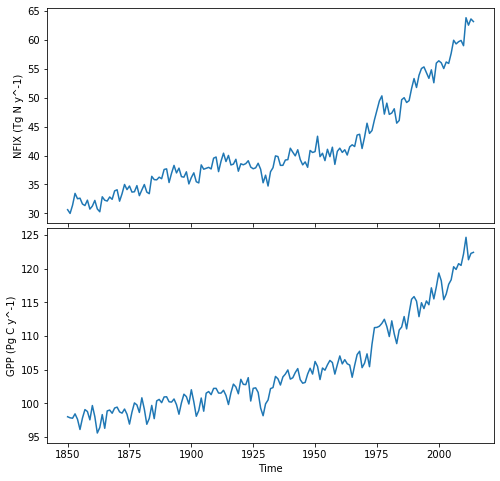

In [11]:
# Create a nicer figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8),sharex=True)
fig.subplots_adjust(hspace=0.02)

ax1.plot(ann_glob.coords['time.year'], ann_glob[var[0]], label=model)
ax2.plot(ann_glob.coords['time.year'], ann_glob[var[1]], label=model)
# Add some labels to the plot
ax1.set_ylabel(var[0]+' (' + ann_glob[var[0]].attrs['units'] +')')
ax2.set_ylabel(var[1]+' (' + ann_glob[var[1]].attrs['units'] +')')
#ax1.set_title(var[0], fontdict={'size':16})
#ax1.legend(loc='upper left');
    
ax2.set_xlabel('Time');


<Figure size 864x576 with 0 Axes>

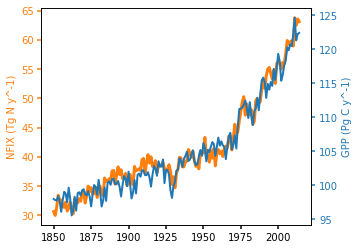

In [12]:
plt.figure(figsize=[12,8])

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()



p1, = host.plot(ann_glob.coords['time.year'], ann_glob[var[0]], 'tab:orange',lw=3, label='NFIX')
p2, = par1.plot(ann_glob.coords['time.year'], ann_glob[var[1]], 'tab:blue', lw=2, label='GPP')

#host.set_xlim(1960, 2015)
#host.set_ylim(-2.8, 2.8)
#par1.set_ylim(-2.3, 2.3)

#host.set_xlabel("Distance")
host.set_ylabel(var[0]+' (' + ann_glob[var[0]].attrs['units'] +')')
par1.set_ylabel(var[1]+' (' + ann_glob[var[1]].attrs['units'] +')')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

------------------------
### Now make a map!

<xarray.DataArray ()>
array(31.67451861)
Attributes:
    units:    gN m-2 y-1 <xarray.DataArray ()>
array(60.83118837)
Attributes:
    units:    gN m-2 y-1 <xarray.DataArray ()>
array(29.15666976)
Attributes:
    units:    gN m-2 y-1


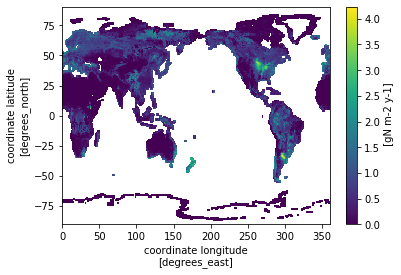

In [13]:
# making a data array, because cyclic_dataarray currently set up that way
x1= mean_dataset.isel(time=slice(0,10)).mean('time')[var[0]] # Climatology for first 10 years of data
x = mean_dataset.isel(time=slice(-10,None)).mean('time')[var[0]] # Climatology for last 10 years of data
xdiff = x - x1

xinit     = x1 * landUp
xfin      = x  * landUp
xdelta    = xdiff * landUp

glob_init   = xinit.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_fin    = xfin.sum(dim=('lat','lon')) * 1e-12 #convert to Tg/y
glob_change = xdelta.sum(dim=('lat','lon')) * 1e-12 #convert to TPg/y
print(glob_init, glob_fin, glob_change)

# Then add cyclic point, ?? is there a better way to do this ??
x1= utils.cyclic_dataarray(x1)  
x = utils.cyclic_dataarray(x)
xdiff = utils.cyclic_dataarray(xdiff)
lat = x.coords['lat']
lon = x.coords['lon']
x.plot();

<Figure size 360x252 with 0 Axes>

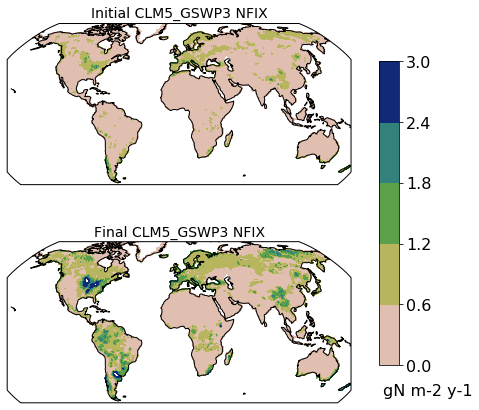

In [15]:
import matplotlib.colors as colors
import cartopy.feature as cfeature

norm = colors.Normalize(vmin=0, vmax=3)
norm(x.mean())

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 3, 6)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('Initial '+model+' '+var[0], fontsize=14)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('Final '+model+' '+var[0], fontsize=14);
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
ax.text(0.2,-0.1,mean_dataset[var[0]].attrs['units'], size=16,rotation=0);
plt.show();

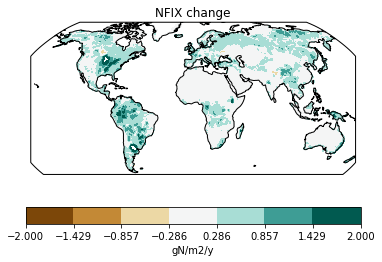

In [17]:
# Now make a difference map
norm = colors.Normalize(vmin=-2., vmax=2.)
norm(xdiff.mean())
levels = np.linspace(-2., 2.,8)

ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??

cs = ax.contourf(lon, lat, xdiff, levels=levels, norm=norm, cmap='BrBG',
                 transform=ccrs.PlateCarree());

# add colorbar.
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label('gN/m2/y')

ax.set_title(var[0] + " change")
plt.show();